In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cert-insider-threat/psychometric.csv
/kaggle/input/cert-insider-threat/email.csv


🔒 Insider Threat Detection - Full Dataset Training Phase
Loading datasets...
Email data: (2629979, 11)
Psychometric data: (1000, 7)
Merged dataset: (2629979, 17)
Preparing features...
Features prepared: (2629979, 18)
Creating anomaly labels...
Anomalies: 131499 out of 2629979 (5.0%)

🚀 Training XGBoost...
Training XGBoost model...
XGBoost Results:
AUC Score: 0.9985
Accuracy: 0.9901
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    499696
     Anomaly       0.95      0.85      0.90     26300

    accuracy                           0.99    525996
   macro avg       0.97      0.92      0.95    525996
weighted avg       0.99      0.99      0.99    525996



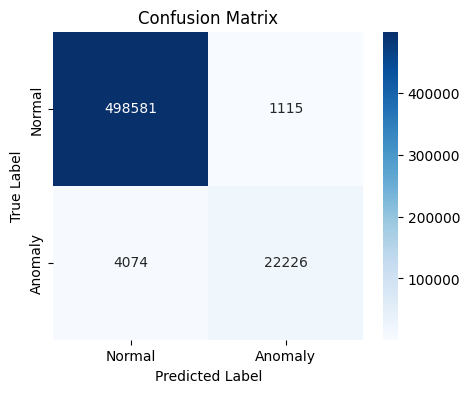

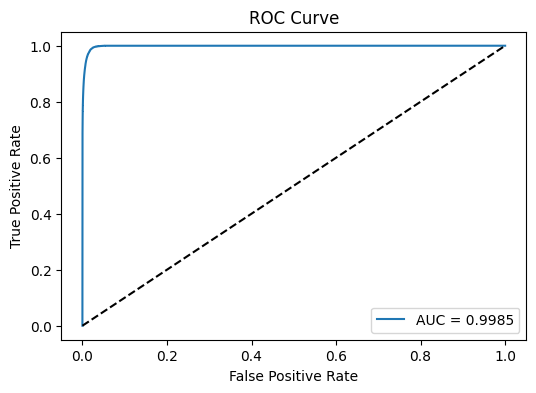

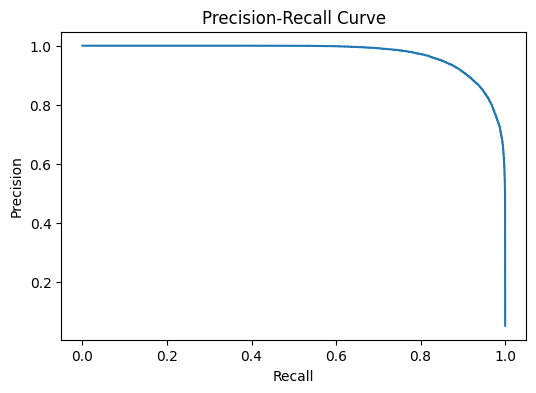

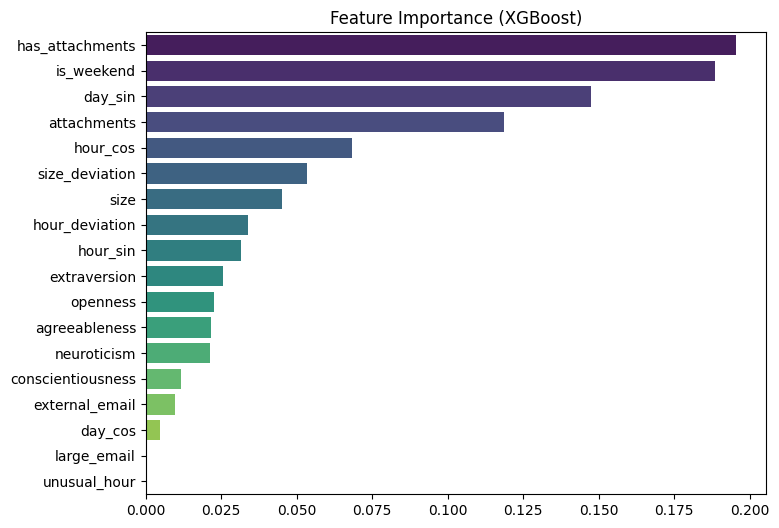


✅ Training completed successfully!


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, accuracy_score
)
import xgboost as xgb

# Set random seed
np.random.seed(42)


class InsiderThreatTrainer:
    def __init__(self, email_path, psycho_path):
        self.email_path = email_path
        self.psycho_path = psycho_path
        self.scaler = StandardScaler()
        self.xgb_model = None
        self.feature_columns = None

    def load_data(self):
        """Load real datasets"""
        print("Loading datasets...")

        self.email_df = pd.read_csv(self.email_path, low_memory=False)
        self.psycho_df = pd.read_csv(self.psycho_path)

        print(f"Email data: {self.email_df.shape}")
        print(f"Psychometric data: {self.psycho_df.shape}")

        # Rename columns for psychometric dataset
        self.psycho_df.rename(columns={
            "user_id": "user",
            "O": "openness",
            "C": "conscientiousness",
            "E": "extraversion",
            "A": "agreeableness",
            "N": "neuroticism"
        }, inplace=True)

        # Merge
        self.merged_df = self.email_df.merge(self.psycho_df, on="user", how="left")
        print(f"Merged dataset: {self.merged_df.shape}")

    def prepare_features(self):
        """Prepare features for ML models"""
        print("Preparing features...")

        # Parse datetime
        self.merged_df['date'] = pd.to_datetime(self.merged_df['date'], errors='coerce')
        self.merged_df['hour'] = self.merged_df['date'].dt.hour
        self.merged_df['day_of_week'] = self.merged_df['date'].dt.dayofweek
        self.merged_df['is_weekend'] = (self.merged_df['day_of_week'] >= 5).astype(int)
        self.merged_df['unusual_hour'] = ((self.merged_df['hour'] < 6) |
                                          (self.merged_df['hour'] > 22)).astype(int)

        # Derived features
        self.merged_df['large_email'] = (self.merged_df['size'] > 100000).astype(int)
        self.merged_df['has_attachments'] = (self.merged_df['attachments'] > 0).astype(int)

        # External email detection (from vs. to domain)
        def get_domain(x):
            if pd.isna(x): return None
            parts = str(x).split('@')
            return parts[-1].lower() if len(parts) > 1 else None

        self.merged_df['from_domain'] = self.merged_df['from'].apply(get_domain)
        self.merged_df['to_domain'] = self.merged_df['to'].apply(get_domain)
        self.merged_df['external_email'] = (
            self.merged_df['from_domain'] != self.merged_df['to_domain']
        ).astype(int)

        # Time encoding
        self.merged_df['hour_sin'] = np.sin(2 * np.pi * self.merged_df['hour'] / 24)
        self.merged_df['hour_cos'] = np.cos(2 * np.pi * self.merged_df['hour'] / 24)
        self.merged_df['day_sin'] = np.sin(2 * np.pi * self.merged_df['day_of_week'] / 7)
        self.merged_df['day_cos'] = np.cos(2 * np.pi * self.merged_df['day_of_week'] / 7)

        # User behavior stats
        user_stats = self.merged_df.groupby('user').agg({
            'size': ['mean', 'std'],
            'hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.mean()
        })
        user_stats.columns = ['avg_size', 'std_size', 'typical_hour']
        user_stats['std_size'] = user_stats['std_size'].fillna(1)

        self.merged_df = self.merged_df.merge(user_stats, left_on='user', right_index=True, how='left')

        # Deviation features
        self.merged_df['size_deviation'] = (
            (self.merged_df['size'] - self.merged_df['avg_size']) /
            self.merged_df['std_size']
        )
        self.merged_df['hour_deviation'] = np.abs(
            self.merged_df['hour'] - self.merged_df['typical_hour']
        )

        # Final feature list
        self.feature_columns = [
            'size', 'attachments', 'external_email',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'is_weekend', 'unusual_hour', 'large_email',
            'has_attachments', 'size_deviation', 'hour_deviation',
            'openness', 'conscientiousness', 'extraversion',
            'agreeableness', 'neuroticism'
        ]

        # Fill missing psychometric data with mean
        for col in self.feature_columns:
            if col not in self.merged_df.columns:
                self.merged_df[col] = 0
            else:
                self.merged_df[col] = self.merged_df[col].fillna(self.merged_df[col].mean())

        self.X = self.merged_df[self.feature_columns].values
        print(f"Features prepared: {self.X.shape}")

    def create_labels(self):
        """Create anomaly labels using Isolation Forest"""
        print("Creating anomaly labels...")
        iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
        anomaly_labels = iso_forest.fit_predict(self.X)
        self.y = (anomaly_labels == -1).astype(int)
        print(f"Anomalies: {self.y.sum()} out of {len(self.y)} ({self.y.mean()*100:.1f}%)")

    def train_xgboost(self):
        """Train XGBoost model and show visualizations"""
        print("Training XGBoost model...")

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42, stratify=self.y
        )

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Train
        self.xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=-1
        )
        self.xgb_model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = self.xgb_model.predict(X_test_scaled)
        y_pred_proba = self.xgb_model.predict_proba(X_test_scaled)[:, 1]

        # Report
        acc = accuracy_score(y_test, y_pred)
        print("XGBoost Results:")
        print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        # Visualizations
        self.visualize_results(y_test, y_pred, y_pred_proba)

    def visualize_results(self, y_test, y_pred, y_pred_proba):
        """Plot confusion matrix, ROC, PR, feature importance"""

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Normal', 'Anomaly'],
                    yticklabels=['Normal', 'Anomaly'])
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.show()

        # Feature Importance
        importance = self.xgb_model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 6))
        sns.barplot(y=np.array(self.feature_columns)[indices],
                    x=importance[indices], palette="viridis")
        plt.title("Feature Importance (XGBoost)")
        plt.show()


def main():
    print("🔒 Insider Threat Detection - Full Dataset Training Phase")
    print("=" * 60)

    # ✅ Kaggle dataset paths
    email_path = "/kaggle/input/cert-insider-threat/email.csv"
    psycho_path = "/kaggle/input/cert-insider-threat/psychometric.csv"

    trainer = InsiderThreatTrainer(email_path, psycho_path)
    trainer.load_data()
    trainer.prepare_features()
    trainer.create_labels()

    print("\n🚀 Training XGBoost...")
    trainer.train_xgboost()

    print("\n✅ Training completed successfully!")


if __name__ == "__main__":
    main()


Loading datasets...
Merged dataset: (2629979, 17)
Training anomalies: 97922 out of 1958427 (5.0%)
Test anomalies: 32697 out of 671552 (4.9%)

🚀 Training XGBoost...
XGBoost Results:
AUC Score: 0.9984
Accuracy: 0.9899
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    638855
     Anomaly       0.95      0.84      0.89     32697

    accuracy                           0.99    671552
   macro avg       0.97      0.92      0.94    671552
weighted avg       0.99      0.99      0.99    671552



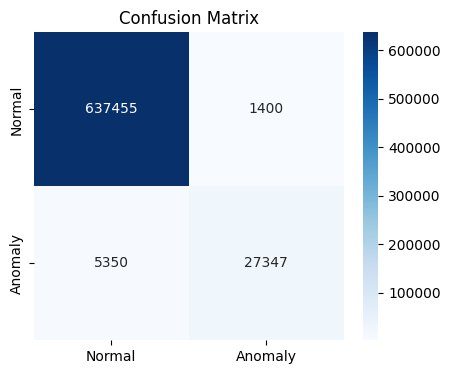

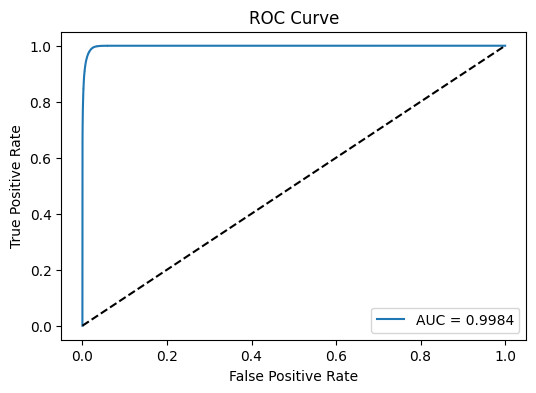

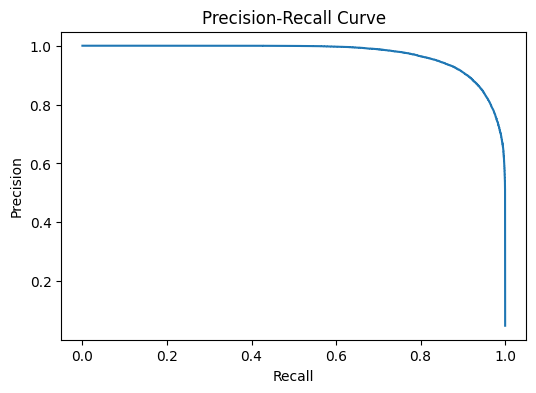

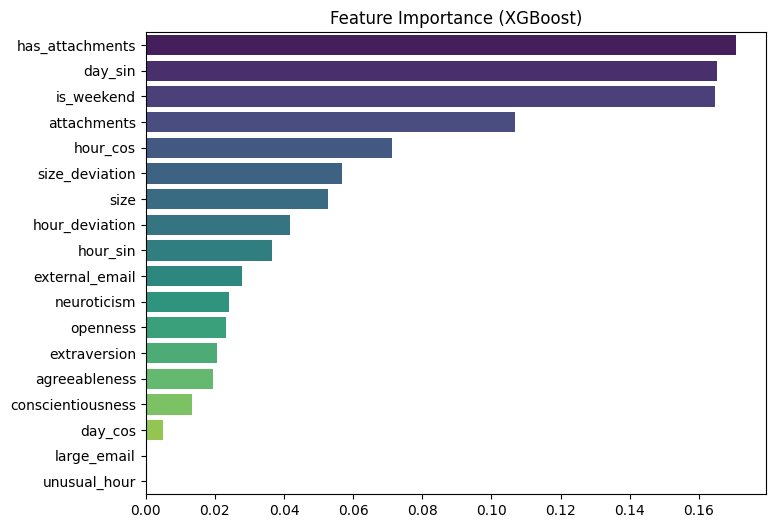


✅ Training completed successfully!


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, accuracy_score
)
import xgboost as xgb

np.random.seed(42)

class InsiderThreatTrainer:
    def __init__(self, email_path, psycho_path):
        self.email_path = email_path
        self.psycho_path = psycho_path
        self.scaler = StandardScaler()
        self.xgb_model = None
        self.feature_columns = None

    def load_data(self):
        print("Loading datasets...")
        self.email_df = pd.read_csv(self.email_path, low_memory=False)
        self.psycho_df = pd.read_csv(self.psycho_path)

        # Rename psychometric columns
        self.psycho_df.rename(columns={
            "user_id": "user",
            "O": "openness",
            "C": "conscientiousness",
            "E": "extraversion",
            "A": "agreeableness",
            "N": "neuroticism"
        }, inplace=True)

        # Merge datasets
        self.merged_df = self.email_df.merge(self.psycho_df, on="user", how="left")
        self.merged_df['date'] = pd.to_datetime(self.merged_df['date'], errors='coerce')
        print(f"Merged dataset: {self.merged_df.shape}")

    def prepare_features(self, train_df):
        # Extract time features
        train_df['hour'] = train_df['date'].dt.hour
        train_df['day_of_week'] = train_df['date'].dt.dayofweek
        train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)
        train_df['unusual_hour'] = ((train_df['hour'] < 6) | (train_df['hour'] > 22)).astype(int)
        train_df['large_email'] = (train_df['size'] > 100000).astype(int)
        train_df['has_attachments'] = (train_df['attachments'] > 0).astype(int)

        # External email detection
        def get_domain(x):
            if pd.isna(x): return None
            parts = str(x).split('@')
            return parts[-1].lower() if len(parts) > 1 else None

        train_df['from_domain'] = train_df['from'].apply(get_domain)
        train_df['to_domain'] = train_df['to'].apply(get_domain)
        train_df['external_email'] = (train_df['from_domain'] != train_df['to_domain']).astype(int)

        # Time encoding
        train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
        train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)
        train_df['day_sin'] = np.sin(2 * np.pi * train_df['day_of_week'] / 7)
        train_df['day_cos'] = np.cos(2 * np.pi * train_df['day_of_week'] / 7)

        # Compute user stats ONLY on training set
        user_stats = train_df.groupby('user').agg({
            'size': ['mean', 'std'],
            'hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.mean()
        })
        user_stats.columns = ['avg_size', 'std_size', 'typical_hour']
        user_stats['std_size'] = user_stats['std_size'].fillna(1)
        train_df = train_df.merge(user_stats, left_on='user', right_index=True, how='left')

        # Deviation features
        train_df['size_deviation'] = (train_df['size'] - train_df['avg_size']) / train_df['std_size']
        train_df['hour_deviation'] = np.abs(train_df['hour'] - train_df['typical_hour'])

        # Feature list
        self.feature_columns = [
            'size', 'attachments', 'external_email',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'is_weekend', 'unusual_hour', 'large_email',
            'has_attachments', 'size_deviation', 'hour_deviation',
            'openness', 'conscientiousness', 'extraversion',
            'agreeableness', 'neuroticism'
        ]

        # Fill missing psychometric data
        for col in self.feature_columns:
            if col not in train_df.columns:
                train_df[col] = 0
            else:
                train_df[col] = train_df[col].fillna(train_df[col].mean())

        X = train_df[self.feature_columns].values
        return X, train_df

    def create_labels(self, X_train):
        iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
        anomaly_labels = iso_forest.fit_predict(X_train)
        y_train = (anomaly_labels == -1).astype(int)
        print(f"Training anomalies: {y_train.sum()} out of {len(y_train)} ({y_train.mean()*100:.1f}%)")
        return y_train, iso_forest

    def train_xgboost(self, X_train, y_train, X_test, y_test):
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=-1
        )
        self.xgb_model.fit(X_train_scaled, y_train)

        y_pred = self.xgb_model.predict(X_test_scaled)
        y_pred_proba = self.xgb_model.predict_proba(X_test_scaled)[:, 1]

        print("XGBoost Results:")
        print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        self.visualize_results(y_test, y_pred, y_pred_proba)

    def visualize_results(self, y_test, y_pred, y_pred_proba):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.title("Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.show()

        importance = self.xgb_model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 6))
        sns.barplot(y=np.array(self.feature_columns)[indices], x=importance[indices], palette="viridis")
        plt.title("Feature Importance (XGBoost)")
        plt.show()


def main():
    email_path = "/kaggle/input/cert-insider-threat/email.csv"
    psycho_path = "/kaggle/input/cert-insider-threat/psychometric.csv"

    trainer = InsiderThreatTrainer(email_path, psycho_path)
    trainer.load_data()

    # Time-based split to avoid leakage
    split_date = '2011-01-01'
    train_df = trainer.merged_df[trainer.merged_df['date'] < split_date].copy()
    test_df  = trainer.merged_df[trainer.merged_df['date'] >= split_date].copy()

    X_train, train_df = trainer.prepare_features(train_df)
    X_test, test_df   = trainer.prepare_features(test_df)

    y_train, iso_forest = trainer.create_labels(X_train)

    # Use trained Isolation Forest to label test set
    test_labels = iso_forest.predict(X_test)
    y_test = (test_labels == -1).astype(int)
    print(f"Test anomalies: {y_test.sum()} out of {len(y_test)} ({y_test.mean()*100:.1f}%)")

    print("\n🚀 Training XGBoost...")
    trainer.train_xgboost(X_train, y_train, X_test, y_test)
    print("\n✅ Training completed successfully!")


if __name__ == "__main__":
    main()


Loading datasets...
Merged dataset: (2629979, 17)
Training anomalies: 97922 out of 1958427 (5.0%)
Test anomalies: 32697 out of 671552 (4.9%)

🚀 Training XGBoost...
XGBoost Results:
AUC Score: 0.9984
Accuracy: 0.9899
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    638855
     Anomaly       0.95      0.84      0.89     32697

    accuracy                           0.99    671552
   macro avg       0.97      0.92      0.94    671552
weighted avg       0.99      0.99      0.99    671552



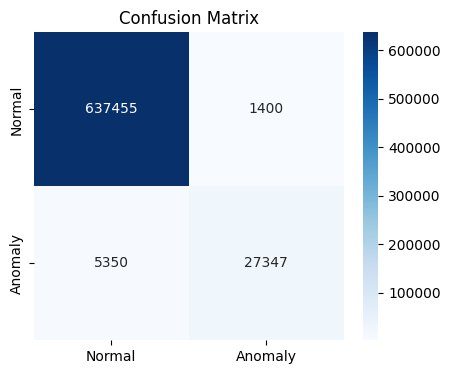

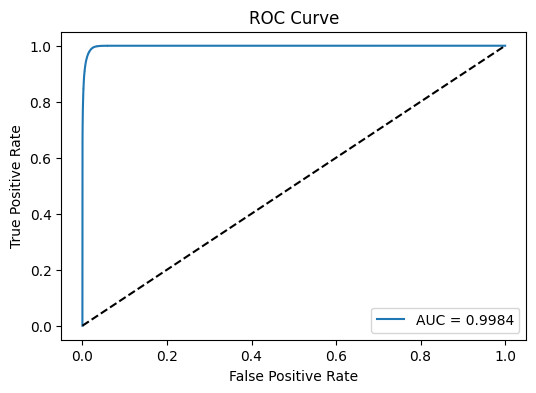

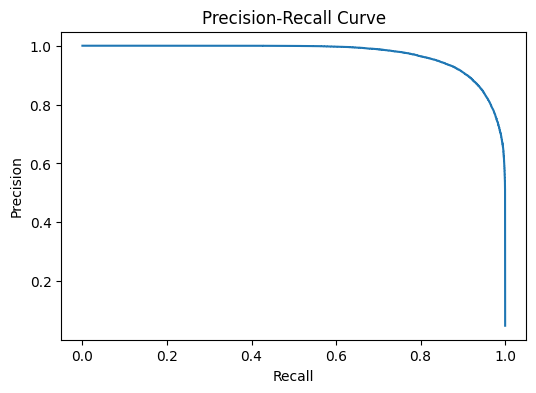

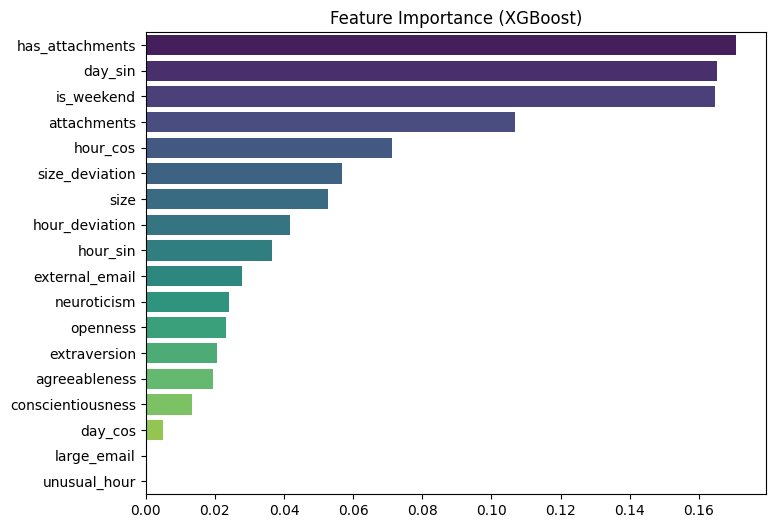


✅ Model and scaler saved in 'models/' folder.

✅ Training completed successfully!


In [6]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, accuracy_score
)
import xgboost as xgb
import joblib  # for saving the model

np.random.seed(42)

class InsiderThreatTrainer:
    def __init__(self, email_path, psycho_path):
        self.email_path = email_path
        self.psycho_path = psycho_path
        self.scaler = StandardScaler()
        self.xgb_model = None
        self.feature_columns = None

    def load_data(self):
        print("Loading datasets...")
        self.email_df = pd.read_csv(self.email_path, low_memory=False)
        self.psycho_df = pd.read_csv(self.psycho_path)

        # Rename psychometric columns
        self.psycho_df.rename(columns={
            "user_id": "user",
            "O": "openness",
            "C": "conscientiousness",
            "E": "extraversion",
            "A": "agreeableness",
            "N": "neuroticism"
        }, inplace=True)

        # Merge datasets
        self.merged_df = self.email_df.merge(self.psycho_df, on="user", how="left")
        self.merged_df['date'] = pd.to_datetime(self.merged_df['date'], errors='coerce')
        print(f"Merged dataset: {self.merged_df.shape}")

    def prepare_features(self, df):
        # Extract time features
        df['hour'] = df['date'].dt.hour
        df['day_of_week'] = df['date'].dt.dayofweek
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['unusual_hour'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
        df['large_email'] = (df['size'] > 100000).astype(int)
        df['has_attachments'] = (df['attachments'] > 0).astype(int)

        # External email detection
        def get_domain(x):
            if pd.isna(x): return None
            parts = str(x).split('@')
            return parts[-1].lower() if len(parts) > 1 else None

        df['from_domain'] = df['from'].apply(get_domain)
        df['to_domain'] = df['to'].apply(get_domain)
        df['external_email'] = (df['from_domain'] != df['to_domain']).astype(int)

        # Time encoding
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Compute user stats
        user_stats = df.groupby('user').agg({
            'size': ['mean', 'std'],
            'hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.mean()
        })
        user_stats.columns = ['avg_size', 'std_size', 'typical_hour']
        user_stats['std_size'] = user_stats['std_size'].fillna(1)
        df = df.merge(user_stats, left_on='user', right_index=True, how='left')

        # Deviation features
        df['size_deviation'] = (df['size'] - df['avg_size']) / df['std_size']
        df['hour_deviation'] = np.abs(df['hour'] - df['typical_hour'])

        # Feature list
        self.feature_columns = [
            'size', 'attachments', 'external_email',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'is_weekend', 'unusual_hour', 'large_email',
            'has_attachments', 'size_deviation', 'hour_deviation',
            'openness', 'conscientiousness', 'extraversion',
            'agreeableness', 'neuroticism'
        ]

        # Fill missing psychometric data
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0
            else:
                df[col] = df[col].fillna(df[col].mean())

        X = df[self.feature_columns].values
        return X, df

    def create_labels(self, X_train):
        iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
        anomaly_labels = iso_forest.fit_predict(X_train)
        y_train = (anomaly_labels == -1).astype(int)
        print(f"Training anomalies: {y_train.sum()} out of {len(y_train)} ({y_train.mean()*100:.1f}%)")
        return y_train, iso_forest

    def train_xgboost(self, X_train, y_train, X_test, y_test):
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=-1
        )
        self.xgb_model.fit(X_train_scaled, y_train)

        y_pred = self.xgb_model.predict(X_test_scaled)
        y_pred_proba = self.xgb_model.predict_proba(X_test_scaled)[:, 1]

        print("XGBoost Results:")
        print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        self.visualize_results(y_test, y_pred, y_pred_proba)

        # Save model and scaler
        os.makedirs("models", exist_ok=True)
        joblib.dump(self.xgb_model, "models/xgb_insider_threat.pkl")
        joblib.dump(self.scaler, "models/scaler.pkl")
        print("\n✅ Model and scaler saved in 'models/' folder.")

    def visualize_results(self, y_test, y_pred, y_pred_proba):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.title("Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.show()

        importance = self.xgb_model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 6))
        sns.barplot(y=np.array(self.feature_columns)[indices], x=importance[indices], palette="viridis")
        plt.title("Feature Importance (XGBoost)")
        plt.show()


def main():
    email_path = "/kaggle/input/cert-insider-threat/email.csv"
    psycho_path = "/kaggle/input/cert-insider-threat/psychometric.csv"

    trainer = InsiderThreatTrainer(email_path, psycho_path)
    trainer.load_data()

    # Time-based split to avoid leakage
    split_date = '2011-01-01'
    train_df = trainer.merged_df[trainer.merged_df['date'] < split_date].copy()
    test_df  = trainer.merged_df[trainer.merged_df['date'] >= split_date].copy()

    X_train, train_df = trainer.prepare_features(train_df)
    X_test, test_df   = trainer.prepare_features(test_df)

    y_train, iso_forest = trainer.create_labels(X_train)

    # Use trained Isolation Forest to label test set
    test_labels = iso_forest.predict(X_test)
    y_test = (test_labels == -1).astype(int)
    print(f"Test anomalies: {y_test.sum()} out of {len(y_test)} ({y_test.mean()*100:.1f}%)")

    print("\n🚀 Training XGBoost...")
    trainer.train_xgboost(X_train, y_train, X_test, y_test)
    print("\n✅ Training completed successfully!")


if __name__ == "__main__":
    main()


Loading datasets...
Merged dataset: (2629979, 17)
Training anomalies: 97922 out of 1958427 (5.0%)
Test anomalies: 32697 out of 671552 (4.9%)

🚀 Training XGBoost...
XGBoost Results:
AUC Score: 0.9984
Accuracy: 0.9899
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99    638855
     Anomaly       0.95      0.84      0.89     32697

    accuracy                           0.99    671552
   macro avg       0.97      0.92      0.94    671552
weighted avg       0.99      0.99      0.99    671552



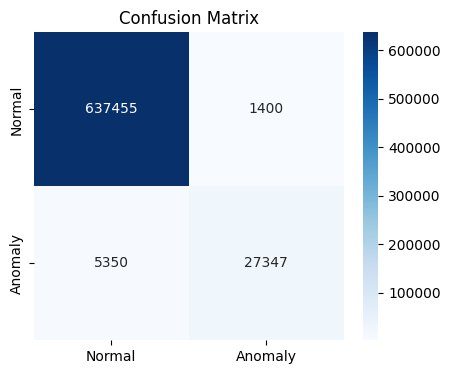

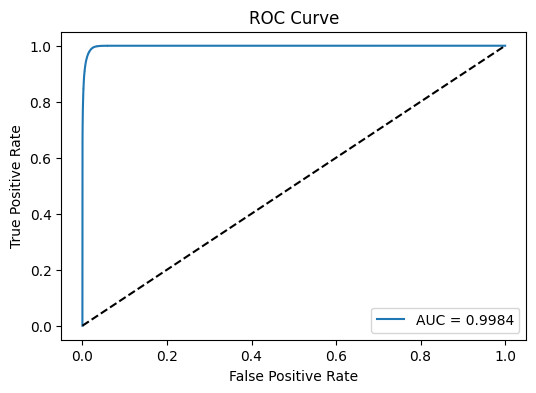

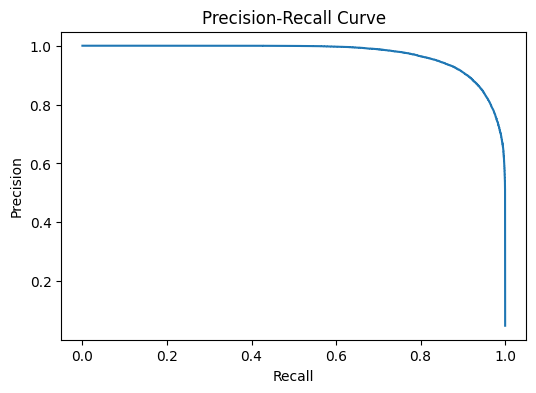

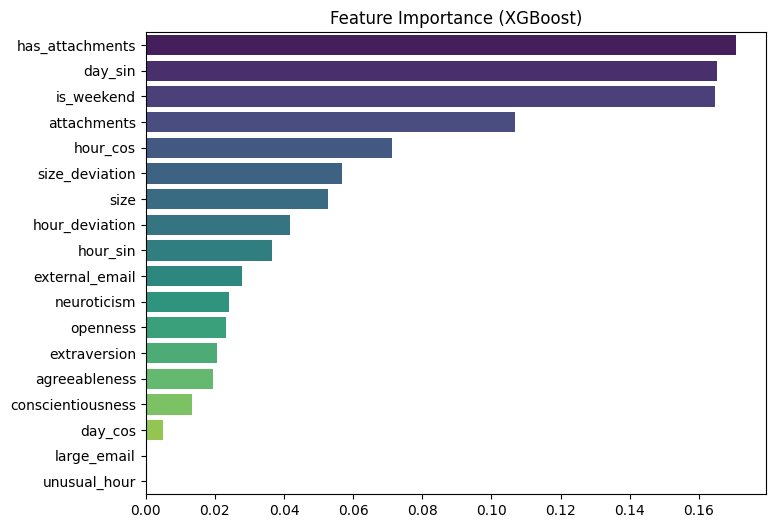


✅ Single model saved as 'models/insider_threat_model.pkl'

✅ Training completed successfully!


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, accuracy_score
)
import xgboost as xgb
import joblib  # single save

np.random.seed(42)

# --- Wrapper class to keep model + scaler together ---
class InsiderThreatModel:
    def __init__(self, model, scaler, feature_columns):
        self.model = model
        self.scaler = scaler
        self.feature_columns = feature_columns

    def predict(self, X_df):
        X = X_df[self.feature_columns].values
        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled)

    def predict_proba(self, X_df):
        X = X_df[self.feature_columns].values
        X_scaled = self.scaler.transform(X)
        return self.model.predict_proba(X_scaled)


class InsiderThreatTrainer:
    def __init__(self, email_path, psycho_path):
        self.email_path = email_path
        self.psycho_path = psycho_path
        self.scaler = StandardScaler()
        self.xgb_model = None
        self.feature_columns = None

    def load_data(self):
        print("Loading datasets...")
        self.email_df = pd.read_csv(self.email_path, low_memory=False)
        self.psycho_df = pd.read_csv(self.psycho_path)

        # Rename psychometric columns
        self.psycho_df.rename(columns={
            "user_id": "user",
            "O": "openness",
            "C": "conscientiousness",
            "E": "extraversion",
            "A": "agreeableness",
            "N": "neuroticism"
        }, inplace=True)

        # Merge datasets
        self.merged_df = self.email_df.merge(self.psycho_df, on="user", how="left")
        self.merged_df['date'] = pd.to_datetime(self.merged_df['date'], errors='coerce')
        print(f"Merged dataset: {self.merged_df.shape}")

    def prepare_features(self, df):
        # Extract time features
        df['hour'] = df['date'].dt.hour
        df['day_of_week'] = df['date'].dt.dayofweek
        df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
        df['unusual_hour'] = ((df['hour'] < 6) | (df['hour'] > 22)).astype(int)
        df['large_email'] = (df['size'] > 100000).astype(int)
        df['has_attachments'] = (df['attachments'] > 0).astype(int)

        # External email detection
        def get_domain(x):
            if pd.isna(x): return None
            parts = str(x).split('@')
            return parts[-1].lower() if len(parts) > 1 else None

        df['from_domain'] = df['from'].apply(get_domain)
        df['to_domain'] = df['to'].apply(get_domain)
        df['external_email'] = (df['from_domain'] != df['to_domain']).astype(int)

        # Time encoding
        df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
        df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
        df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

        # Compute user stats
        user_stats = df.groupby('user').agg({
            'size': ['mean', 'std'],
            'hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else x.mean()
        })
        user_stats.columns = ['avg_size', 'std_size', 'typical_hour']
        user_stats['std_size'] = user_stats['std_size'].fillna(1)
        df = df.merge(user_stats, left_on='user', right_index=True, how='left')

        # Deviation features
        df['size_deviation'] = (df['size'] - df['avg_size']) / df['std_size']
        df['hour_deviation'] = np.abs(df['hour'] - df['typical_hour'])

        # Feature list
        self.feature_columns = [
            'size', 'attachments', 'external_email',
            'hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'is_weekend', 'unusual_hour', 'large_email',
            'has_attachments', 'size_deviation', 'hour_deviation',
            'openness', 'conscientiousness', 'extraversion',
            'agreeableness', 'neuroticism'
        ]

        # Fill missing psychometric data
        for col in self.feature_columns:
            if col not in df.columns:
                df[col] = 0
            else:
                df[col] = df[col].fillna(df[col].mean())

        X = df[self.feature_columns].values
        return X, df

    def create_labels(self, X_train):
        iso_forest = IsolationForest(contamination=0.05, random_state=42, n_jobs=-1)
        anomaly_labels = iso_forest.fit_predict(X_train)
        y_train = (anomaly_labels == -1).astype(int)
        print(f"Training anomalies: {y_train.sum()} out of {len(y_train)} ({y_train.mean()*100:.1f}%)")
        return y_train, iso_forest

    def train_xgboost(self, X_train, y_train, X_test, y_test):
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.xgb_model = xgb.XGBClassifier(
            n_estimators=150,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=-1
        )
        self.xgb_model.fit(X_train_scaled, y_train)

        y_pred = self.xgb_model.predict(X_test_scaled)
        y_pred_proba = self.xgb_model.predict_proba(X_test_scaled)[:, 1]

        print("XGBoost Results:")
        print(f"AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(classification_report(y_test, y_pred, target_names=['Normal', 'Anomaly']))

        self.visualize_results(y_test, y_pred, y_pred_proba)

       

    def visualize_results(self, y_test, y_pred, y_pred_proba):
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
        plt.title("Confusion Matrix")
        plt.show()

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.4f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()

        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(recall, precision)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.show()

        importance = self.xgb_model.feature_importances_
        indices = np.argsort(importance)[::-1]
        plt.figure(figsize=(8, 6))
        sns.barplot(y=np.array(self.feature_columns)[indices], x=importance[indices], palette="viridis")
        plt.title("Feature Importance (XGBoost)")
        plt.show()


def main():
    email_path = "/kaggle/input/cert-insider-threat/email.csv"
    psycho_path = "/kaggle/input/cert-insider-threat/psychometric.csv"

    trainer = InsiderThreatTrainer(email_path, psycho_path)
    trainer.load_data()

    # Time-based split to avoid leakage
    split_date = '2011-01-01'
    train_df = trainer.merged_df[trainer.merged_df['date'] < split_date].copy()
    test_df  = trainer.merged_df[trainer.merged_df['date'] >= split_date].copy()

    X_train, train_df = trainer.prepare_features(train_df)
    X_test, test_df   = trainer.prepare_features(test_df)

    y_train, iso_forest = trainer.create_labels(X_train)

    # Use trained Isolation Forest to label test set
    test_labels = iso_forest.predict(X_test)
    y_test = (test_labels == -1).astype(int)
    print(f"Test anomalies: {y_test.sum()} out of {len(y_test)} ({y_test.mean()*100:.1f}%)")

    print("\n🚀 Training XGBoost...")
    trainer.train_xgboost(X_train, y_train, X_test, y_test)
    print("\n✅ Training completed successfully!")


if __name__ == "__main__":
    main()
